In [1]:
from urllib.request import *
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import scipy.stats as stats
import pylab as pl
import requests
import json
from pygsp import graphs, filters, plotting
import os
import time
from tempfile import TemporaryFile
from datetime import datetime
import matplotlib.pyplot as plt
from collections import Counter
from scipy import sparse, stats, spatial
import scipy.sparse.linalg
import networkx as nx
from pylab import rcParams
plotting.BACKEND = 'matplotlib'
%matplotlib inline

Load players reference:

In [2]:
with open("../scraper/data/players_ref.json", "r") as in_file:
    players_ref_list = json.load(in_file)

In [3]:
print ("We have {} players".format(len(players_ref_list)))

We have 12075 players


In [4]:
# Define method to parse player given player url
def parsePlayer(player_ref):    
    playerID = player_ref.split("/")[-1]
    
    with open("../scraper/data/players/" + playerID + "/page.html") as in_file:
        player_page = json.load(in_file)
    
    response = BeautifulSoup(player_page, 'html.parser')
    
    playerInfos = str(response.find("table", {"class":"auflistung"}))
    player = {}
    player["href"] = player_ref
    try:
        player["number"] = response.find("span", {"class":"dataRN"}).text
    except:
        player["number"] = None
    player["name"] = response.find("h1", {"itemprop":"name"}).text
    player["player_id"] = player_ref.split("/")[-1]
    position = BeautifulSoup(playerInfos.split("Position")[1], 'html.parser').find("td").text
    reg = re.compile( "[a-zA-Z -]")
    player["position"] = "".join(reg.findall(position))
    try:
        player["birthdate"] = BeautifulSoup(playerInfos.split("Date of birth")[1], 'html.parser').find("td").text
    except:
        player["birthdate"] = None
    player["nationality"] = BeautifulSoup(playerInfos.split("Nationality")[1], 'html.parser').find("td").find("img")["title"]
    player["current_club"] = BeautifulSoup(playerInfos.split("Current club")[1], 'html.parser').find("td").find_all("a")[-1].text

    try:
        transfers = []
        trans = response.find("div",{"class" : "box transferhistorie"}).find("table").find("tbody").find_all("tr", {"class":"zeile-transfer"})

        for t in trans:
            transfer = {}
            transfer["player"] = player_ref.split("/")[-1]
            transfer["date"] = t.find_all("td", {"class":"zentriert hide-for-small"})[1].text
            transfer["from"] = t.find_all("td", {"class":"no-border-rechts vereinswappen"})[0].find("a")["id"]
            transfer["to"] = t.find_all("td", {"class":"no-border-rechts vereinswappen"})[1].find("a")["id"]
            if (t.find("td", {"class":"zelle-abloese"}).text) == "End of loan" or t.find("td", {"class":"zelle-abloese"}).text =="Loan":
                transfer["fee"] = t.find("td", {"class":"zelle-mw"}).text
            else:
                transfer["fee"] = t.find("td",{"class":"zelle-abloese"}).text
            transfers.append(transfer)
    except:
        transfers = None
        
    return player, transfers

In [5]:
# Example test of what the function would return
player_test = parsePlayer(players_ref_list[0])
player_test

({'birthdate': 'May 11, 1992 ',
  'current_club': 'Chelsea FC',
  'href': '/thibaut-courtois/profil/spieler/108390',
  'name': 'Thibaut Courtois',
  'nationality': 'Belgium',
  'number': '#13',
  'player_id': '108390',
  'position': 'Goalkeeper'},
 [{'date': 'Jun 30, 2014',
   'fee': '25,00 Mill. €',
   'from': '13',
   'player': '108390',
   'to': '631'},
  {'date': 'Jul 27, 2011',
   'fee': 'Loan fee:1,20 Mill. €',
   'from': '631',
   'player': '108390',
   'to': '13'},
  {'date': 'Jul 26, 2011',
   'fee': '8,95 Mill. €',
   'from': '1184',
   'player': '108390',
   'to': '631'},
  {'date': 'Jul 1, 2009',
   'fee': '-',
   'from': '3494',
   'player': '108390',
   'to': '1184'},
  {'date': 'Jul 1, 2008',
   'fee': '-',
   'from': '49393',
   'player': '108390',
   'to': '3494'},
  {'date': 'Jul 1, 2007',
   'fee': '-',
   'from': '34282',
   'player': '108390',
   'to': '49393'}])

### Data exploration and preprocessing functions
From the example above, one concern one can raise is the fact that the transfer fee is represented in a way that combines digits and characters. We want to cast the fee of transfer from string to int. All currencies are expressed in euros. We have found the below relations: <br/>
Mill. is used for millions <br/>
Th. is used for thousands <br/>
\- or ? is used to mark missing entry <br/>
Free Transfer is used to mark 0 value <br/>
Loan fee:amount is used to mark the value under a loan <br/>

In [6]:
missing_fees = 0
# This function will transform the fees of a player from a string to a number so that it can be used as a weight for the edges
def fix_fee(player_fee):
    # missing_fees is to count the number of 
    global missing_fees
    try:
        player_fee = player_fee.replace(":",": ").replace(",",".")
    except:
        pass
    if re.search(r'\d+.\d+', player_fee) is not None:
        fee = float(re.search(r'\d+.\d+', player_fee).group())
    else:
        fee = 0
    
    if fee > 0:
        if "Mill." in player_fee:
            processed_fee = int(fee*1000000)
        elif "Th." in player_fee:
            processed_fee = int(fee*1000)
        else:
            processed_fee = int(fee)
    else:
        missing_fees += 1
        processed_fee = 0
    
    return processed_fee

## Build graph of transfers

In [7]:
with open("../scraper/data/clubs.json", "r") as in_file:
    clubs_ref_list = json.load(in_file)

In [8]:
# We need to reduce the number of nodes to actual number of clubs. However, this will make us lose the indexing
width = len(clubs_ref_list)
print ("The number of clubs that are valued above 200 Million Euros are {}".format(len(clubs_ref_list)))

The number of clubs that are valued above 200 Million Euros are 418


### Build the graph ranked by value of club

We would like to build a graph that displays the interaction among clubs. An interaction is decided by if a player goes from one club to another (or vice versa). We have reasons to believe that clubs that have higher market values may tend to have more transfers among them, and clubs with smaller market values tend to interact more among each other. For this reason, we will build an adjacency matrix to build a graph sorted by the club's value.

In [9]:
# Our adjacency matrix should be 418x418
W = np.zeros((width,width))

In [10]:
# Create a list of tuple consisting of club id and market_value
club_pairs = []
for club in clubs_ref_list:
    club_id = int(club['href'].split("/")[-3])
    club_market_value = int(fix_fee(club["market_value"]))
    club_pairs.append(tuple((club_market_value,club_id)))

# Sort list based on market value
club_pairs = sorted(club_pairs, key=lambda tup: tup[0])

club_ids = []

# Create a new list with the sorted club_ids based on their market value
for club in club_pairs:
    club_ids.append(club[1])

There are some players that are being transfered from one club to another, with the clubs being small (smaller than our criteria). The total number of clubs found was equal to 7200, however, we are only interested in the big clubs that we found were only 418. <br/>
We will add a constraint when adding the node.

In [11]:
# Fill the Adjacency matrix with one (W[i][j] == 1) when transfer from one club to another
# Where the two clubs match our 200 million euros valuation criteria
for player_ref in players_ref_list:
    player = parsePlayer(player_ref)
    try:
        for transfer in player[1]:
            from_club = int(transfer["from"])
            to_club = int(transfer["to"])
            if(from_club in club_ids and to_club in club_ids):
                W[club_ids.index(from_club)][club_ids.index(to_club)] = 1
                W[club_ids.index(to_club)][club_ids.index(from_club)] = 1
    except:
        pass

In [12]:
# Some transfers are within the same club. When a player contract came to an end.
number_of_inner_transfers = 0
for i in range(W.shape[0]):
    if(W[i][i] == 1):
        number_of_inner_transfers += 1
        
print ("There have been {} innertransfers".format(number_of_inner_transfers))

There have been 2 innertransfers


In [13]:
# Set all the transfers within the same club to zero -> no self-loops
# Ignore innertransfers
np.fill_diagonal(W, 0)

In [14]:
# Create a temporary matrix so we wouldn't need to recompute W if we later need to go back to our result
np.save('adj_matrix.npy', W)

## Load directly filled matrix

In [15]:
# Load W matrix from pre-saved model
W = np.load('adj_matrix.npy')

In [16]:
# Build graph from G
G = graphs.Graph(W)
print('{} nodes, {} edges'.format(G.N, G.Ne))

418 nodes, 6714 edges


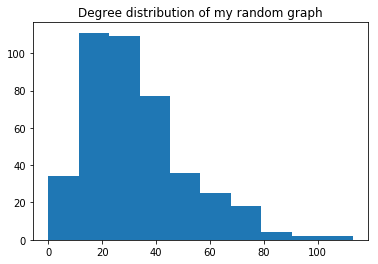

In [17]:
plt.hist(G.d)
plt.title('Degree distribution of my random graph');

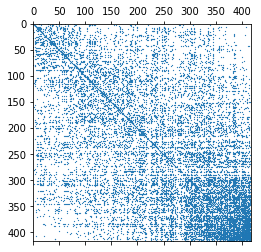

In [18]:
G.compute_laplacian('combinatorial')

plt.spy(G.L, markersize=0.30)


We can see from the graph above that all clubs do interact with each other, however there seems to be a formation of two clusters where interactions are more dense, that is the top 100 clubs (from a market value perspective) and the lowest 100 clubs (among the 418 considered clubs).

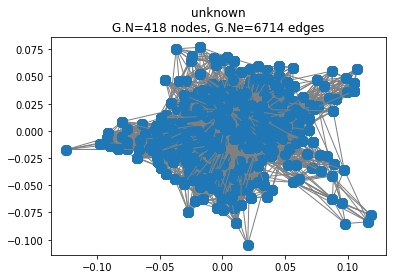

In [19]:
G.set_coordinates('spring')
plotting.plot_graph(G)

## Compute eigenvalues and eigenvectors

In [20]:
# Build graph using networkX and adjacency matrix W
G=nx.from_numpy_matrix(W)
laplacian = nx.normalized_laplacian_matrix(G)

In [21]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigs(laplacian, k = 10, which = 'SM')
print (eigenvalues)
print (eigenvectors.shape)

[  2.26177619e-01+0.j   2.54249921e-01+0.j   2.82996063e-01+0.j
   3.08008115e-01+0.j  -1.58578049e-16+0.j  -1.30708429e-16+0.j
  -6.08500439e-17+0.j  -2.18073957e-17+0.j   6.92274751e-17+0.j
  -4.87314436e-21+0.j]
(418, 10)


/Users/fayezmourad/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


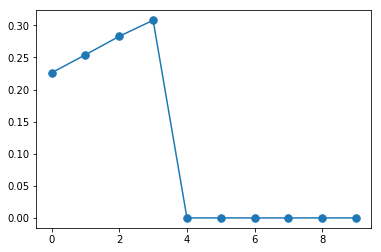

In [22]:
plt.plot(eigenvalues, '.-', markersize=15);

### Build graph based on geographic locations

We have reasons to believe that players in a certain country, will tend to transfer to another club in the same country. For this reason, we would like to build our adjacency matrix with the clubs in the same country be next to each other in the indexing.

In [23]:
# Our adjacency matrix should be 418x418
W = np.zeros((width,width))

In [24]:
club_ids = []
for club in clubs_ref_list:
    club_ids.append(int(club['href'].split("/")[-3]))
    
club_ids = sorted(club_ids)

In [25]:
# Use google api to get the country where each club is located
GOOGLE_MAPS_API_URL = 'http://maps.googleapis.com/maps/api/geocode/json'
club_pairs = []
count_exception = 0
# From google maps api, get the country of each club
for club in clubs_ref_list:
    club_id = int(club['href'].split("/")[-3])
    try:
        params = {
            'address': club["stadium"] + " " + club["name"]
        }
        # Do the request and get the response data
        req = requests.get(GOOGLE_MAPS_API_URL, params=params)
        res = req.json()
        # Use the first result
        if len(res['results']) > 0:
            result = res['results'][0]['address_components']
            for elem in result:
                if elem['types'][0] == 'country':
                    club_country = elem['long_name']
        club_pairs.append(tuple((club_country,club_id)))
    except:
        # If we weren't able to get the country of the club, we want to have it marked
        club_country = "Country not found"
        club_pairs.append(tuple((club_country,club_id)))
        count_exception = count_exception + 1
        pass
    
print ("Not able to find country for {} clubs".format(count_exception))

Not able to find country for 0 clubs


In [26]:
# Sort club pairs based on the country name
club_pairs = sorted(club_pairs, key=lambda tup: tup[0])

club_ids = []

# club_ids are now sorted based on the country
for club in club_pairs:
    club_ids.append(club[1])


In [28]:
# Fill the Adjacency matrix with one when transfer from one club to another
# Where the two clubs match our 200 million euros valuation criteria
for player_ref in players_ref_list:
    player = parsePlayer(player_ref)
    try:
        for transfer in player[1]:
            from_club = int(transfer["from"])
            to_club = int(transfer["to"])
            if(from_club in club_ids and to_club in club_ids):
                W[club_ids.index(from_club)][club_ids.index(to_club)] = 1
                W[club_ids.index(to_club)][club_ids.index(from_club)] = 1
    except:
        pass

In [29]:
# Set all the transfers within the same club to zero -> no self-loops
np.fill_diagonal(W, 0)

In [30]:
# Create a temporary matrix so we wouldn't need to recompute W if we later need to go back to our result
np.save('adj_matrix_sorted_country.npy', W)

In [31]:
# Load W matrix from pre-saved model
W = np.load('adj_matrix_sorted_country.npy')

In [32]:
# Build graph from G
G = graphs.Graph(W)
print('{} nodes, {} edges'.format(G.N, G.Ne))

418 nodes, 6714 edges


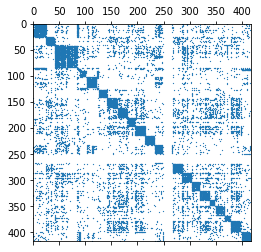

In [33]:
G.compute_laplacian('combinatorial')

plt.spy(G.L, markersize=0.30)

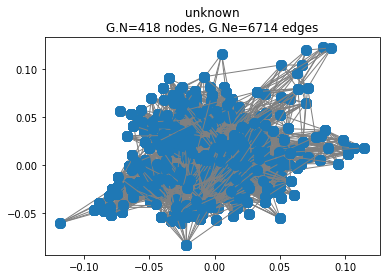

In [34]:
G.set_coordinates('spring')
plotting.plot_graph(G)

# Data visualization/exploration

In [ ]:
# compute the average number of times a player changes clubs
number_of_transfers = 0

for player_ref in players_ref_list:
    player = parsePlayer(player_ref)
    try:
        number_of_transfers += len(player[1])
    except:
        # Don't add anything, since the player didn't transfer
        pass
    
print ("The average player from our dataset has transferred {} many times".format(number_of_transfers/len(players_ref_list)))

In [36]:
player_nationalities = []
birthdays_month = []
counter = 0

for player_ref in players_ref_list:
    player = parsePlayer(player_ref)
    if counter % 1000 == 0:
        print ("We have processed {} players till now.".format(counter))
    try:
        player_nationalities.append(player[0]['nationality'])
        bday = player[0]["birthdate"].replace(",","").strip()
        datetime_object = datetime.strptime(bday, '%b %d %Y')
        birthdays_month.append(datetime_object.month)
    except:
        player_nationalities.append("N/A")
        # Mark not available birthday month by 13
        birthdays_month.append("13")
    counter += 1

We have processed 0 players till now.
We have processed 1000 players till now.
We have processed 2000 players till now.
We have processed 3000 players till now.
We have processed 4000 players till now.
We have processed 5000 players till now.
We have processed 6000 players till now.
We have processed 7000 players till now.
We have processed 8000 players till now.
We have processed 9000 players till now.
We have processed 10000 players till now.
We have processed 11000 players till now.
We have processed 12000 players till now.


### Players nationalities

In [37]:
# Sort nationalities by most common
nationalities_counter = Counter(player_nationalities).most_common(20)
index = []
iterator = 1
nationalities = []
nationalities_count = []
for nationality in nationalities_counter:
    index.append(iterator)
    iterator += 1
    nationalities.append(nationality[0])
    nationalities_count.append(nationality[1])

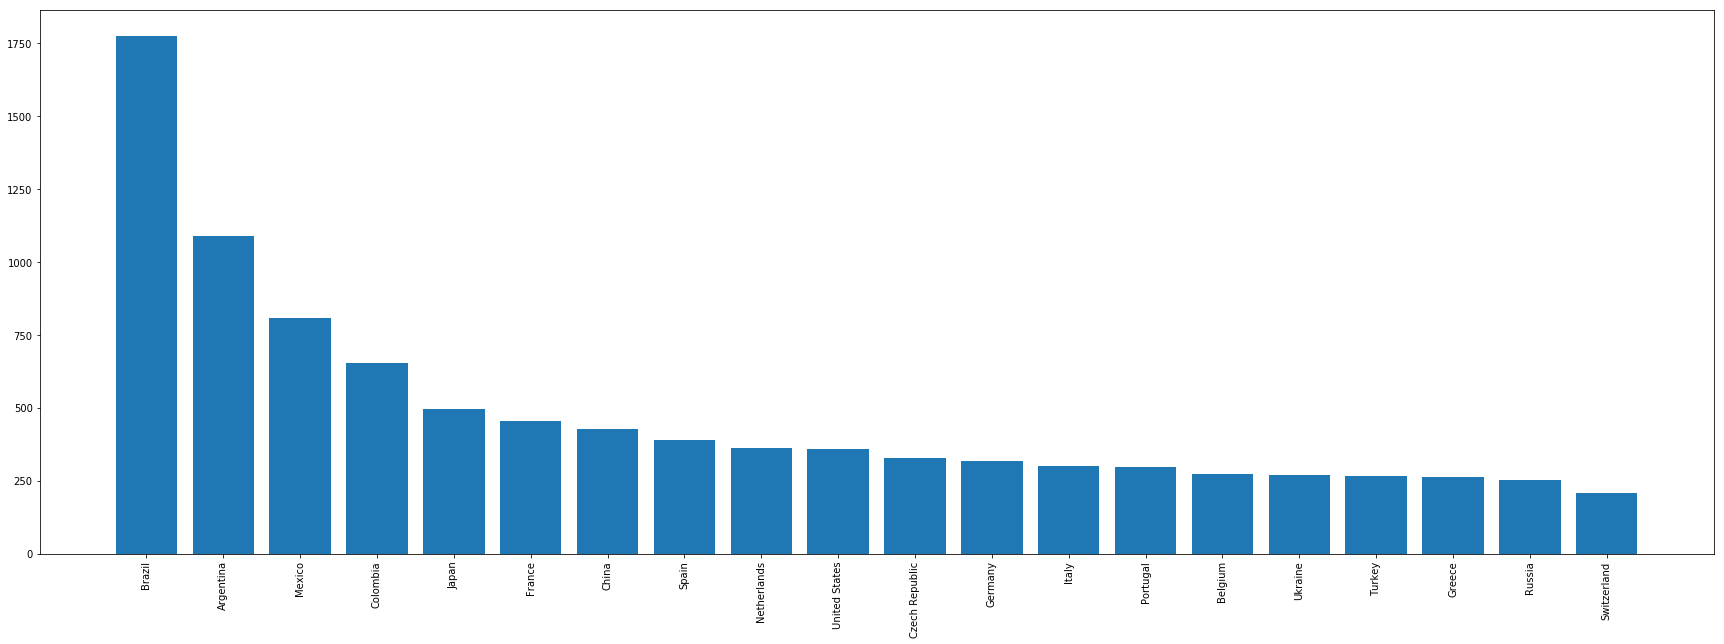

In [38]:
rcParams['figure.figsize'] = 30, 10
plt.bar(index, nationalities_count, align='center')
plt.xticks(index, nationalities,rotation=90)
plt.show()


### Clubs per country

In [39]:
# Visualize how many clubs each country has
clubs_country = []
for club in club_pairs:
    clubs_country.append(club[0])


In [40]:
clubs_country = Counter(clubs_country).most_common()

index = []
iterator = 1
countries = []
country_count = []

for country in clubs_country:
    index.append(iterator)
    iterator += 1
    countries.append(country[0])
    country_count.append(country[1])

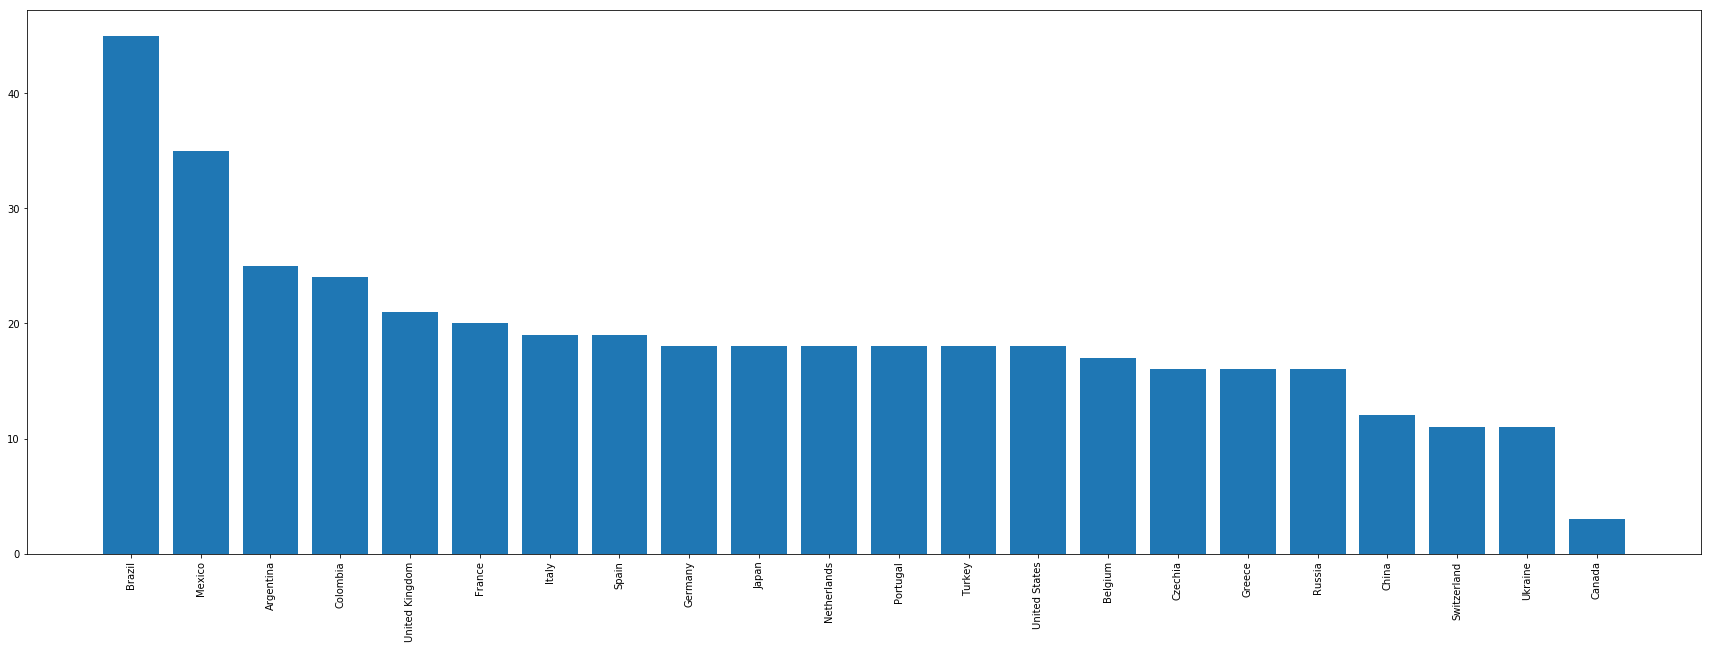

In [41]:
rcParams['figure.figsize'] = 30, 10
plt.bar(index, country_count, align='center')
plt.xticks(index, countries,rotation=90)
plt.show()

### Player birthday distribution

In [42]:
birthdays_month = list(map(int, birthdays_month))
player_birthdays_month = Counter(birthdays_month).most_common()

player_birthdays_month = sorted(player_birthdays_month)

index = []
iterator = 1
months = []
month_count = []

for country in player_birthdays_month:
    index.append(iterator)
    iterator += 1
    months.append(country[0])
    month_count.append(country[1])

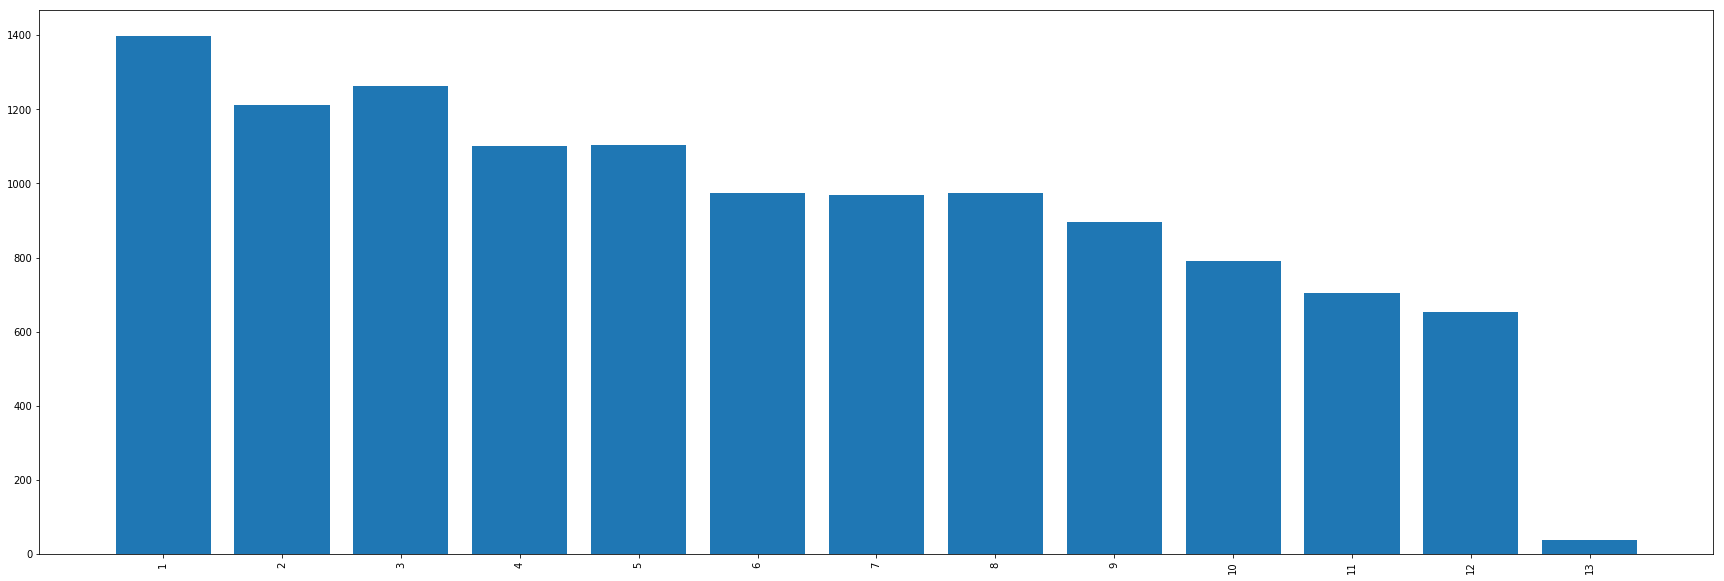

In [43]:
rcParams['figure.figsize'] = 30, 10
plt.bar(index, month_count, align='center')
plt.xticks(index, months,rotation=90)
plt.show()

***According to the book "Outliers" by Malcolm Gladwell, the distribution of professional athletes should be skewed. It is linked with the fact that when children are less than 10 years old, a month's difference in age makes a different from a performance point of view. The players who were born in the early phase of the year had a physical advantage over the other kids and had higher chances of being selected into clubs (usually the player selection is at a young age, less than or equal to 10 years old). This selection would cause a player to train more than the rest and hence higher his chances of becoming a professional atheles (hence professional football player). The arguments given by Malcolm Gladwell are shown to hold, specially since the distribution of birth is equally distributed with respect to month of birth.***